# Scaling Numerical Data is desirable

In [ ]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv(dotenv_path=Path("../.env"))

In [ ]:
%load_ext google.cloud.bigquery
import os
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f"../{os.environ.get('GCP_KEY_FILE')}"
bq = bigquery.Client()

In [4]:
from sklearn import datasets, linear_model
import timeit

diabeters_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
raw = diabeters_X[:, None, 2]
max_raw = max(raw)
min_raw = min(raw)
scaled = (2*raw - max_raw - min_raw)/(max_raw - min_raw)

def train_raw():
  linear_model.LinearRegression().fit(raw, diabetes_y)

def train_scaled():
  linear_model.LinearRegression().fit(scaled, diabetes_y)

raw_time = timeit.timeit(train_raw, number=1000)
scaled_time = timeit.timeit(train_scaled, number=1000)
print(raw_time, scaled_time)

0.3701684000000114 0.2689617999999996


# Pattern 1: Hashed Features

In [1]:
%%bigquery df

CREATE TEMPORARY FUNCTION hashed(airport STRING, numbuckets INT64) AS (
   ABS(MOD(FARM_FINGERPRINT(airport), numbuckets)) 
);

WITH airports AS (
SELECT 
   DISTINCT(departure_airport)
FROM `bigquery-samples.airline_ontime_data.flights`
)

SELECT 
   departure_airport,
   hashed(departure_airport, 3) AS hash3,
   hashed(departure_airport, 10) AS hash10,
   hashed(departure_airport, 1000) AS hash1000,
FROM airportsCREATE

UsageError: Cell magic `%%bigquery` not found.


In [ ]:
# Implementation in tensorflow
import tensorflow as tf
tf.feature_column.categorical_column_with_hash_bucket(
  airport,
  num_buckets,
  dtype=tf.dtypes.string
)

---

# Design Pattern 2: Embeddings

In [2]:
import tensorflow as tf
plurality = tf.feature_column.categorical_column_with_vocabulary_list(
	'plurality',
	['Single(1)', 'Multiple(2+)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)']	
)
plurality_embed = tf.feature_column.embedding_column(plurality, dimension=2)
plurality_embed

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='plurality', vocabulary_list=('Single(1)', 'Multiple(2+)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x0000018682B9A6D0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)

In [25]:
import os
import pandas as pd

LOGDIR = "text_models"
DATA_DIR = "data"
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


In [26]:
# Find out 
# 1. How many words in the dataset
# 2. How many titles in the dataset
# 3. Max length og the titles
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df['title'])
integerized_titles = tokenizer.texts_to_sequences(titles_df['title'])

In [27]:
# integerized_titles contains the integer representation of each article title in the dataset
integerized_titles[:3]

[[6117, 560, 8577, 13948, 302, 13, 172],
 [11, 12, 2, 49, 7, 3838, 1322, 91, 4, 28, 482],
 [11, 12, 1501, 2812, 322, 5, 589, 7337, 5458, 78, 108, 1989, 17, 1139]]

In [28]:
VOCAB_SIZE = len(tokenizer.index_word)
DATASET_SIZE = tokenizer.document_count
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
VOCAB_SIZE, DATASET_SIZE, MAX_LEN

(47271, 96203, 26)

__Preprocess data__

Pad elements of the titles to match the longest entry. `create_sequences` will do this for us

In [29]:
from keras.utils import pad_sequences
def create_sequences(texts, max_len=MAX_LEN):
  sequences = tokenizer.texts_to_sequences(texts)
  padded_sequences = pad_sequences(
    sequences,
    max_len,
    padding='post'
  )
  return padded_sequences

create_sequences(['holy cash cow batman - content is back', 'close look at a flu outbreak upends some common wisdom'])

array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1030,   316,    23,     2,  3718,  7338, 13949,   214,   715,
         4581,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]])

In [30]:
CLASSES = {
	'github': 0,
  'nytimes': 1,
  'techcrunch': 2 
}
N_CLASSES = len(CLASSES)

In [31]:
import keras.utils as utils
def encode_labels(sources):
  classes = [CLASSES[source] for source in sources]
  one_hots = utils.to_categorical(classes)
  return one_hots

In [32]:
N_TRAIN = int(DATASET_SIZE * 0.8)
titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_train, sources_train = (
	titles_df['title'][:N_TRAIN], titles_df['source'][:N_TRAIN]
)
titles_valid, sources_valid = (
	titles_df['title'][N_TRAIN:], titles_df['source'][N_TRAIN:]
)

X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

__BUILD DNN MODEL__

A compiled Keras model that implements a single embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer returning the probabilities for each class

In [33]:
from keras import models, layers
def build_dnn_model(embed_dim):
  model = models.Sequential([
    layers.Embedding(VOCAB_SIZE + 1,
                     embed_dim,
                     input_shape=[MAX_LEN]),
    layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
    layers.Dense(N_CLASSES, activation='softmax')
  ])

  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

Epoch 1/100
257/257 [==============================] - 4s 7ms/step - loss: 1.0484 - accuracy: 0.4305 - val_loss: 0.9783 - val_accuracy: 0.5709
Epoch 2/100
257/257 [==============================] - 1s 6ms/step - loss: 0.8874 - accuracy: 0.6806 - val_loss: 0.8048 - val_accuracy: 0.7197
Epoch 3/100
257/257 [==============================] - 1s 6ms/step - loss: 0.7335 - accuracy: 0.7794 - val_loss: 0.6823 - val_accuracy: 0.7831
Epoch 4/100
257/257 [==============================] - 1s 6ms/step - loss: 0.6276 - accuracy: 0.8083 - val_loss: 0.5985 - val_accuracy: 0.8042
Epoch 5/100
257/257 [==============================] - 1s 6ms/step - loss: 0.5510 - accuracy: 0.8257 - val_loss: 0.5378 - val_accuracy: 0.8176
Epoch 6/100
257/257 [==============================] - 1s 6ms/step - loss: 0.4937 - accuracy: 0.8393 - val_loss: 0.4937 - val_accuracy: 0.8237
Epoch 7/100
257/257 [==============================] - 2s 6ms/step - loss: 0.4500 - accuracy: 0.8490 - val_loss: 0.4610 - val_accuracy: 0.8331

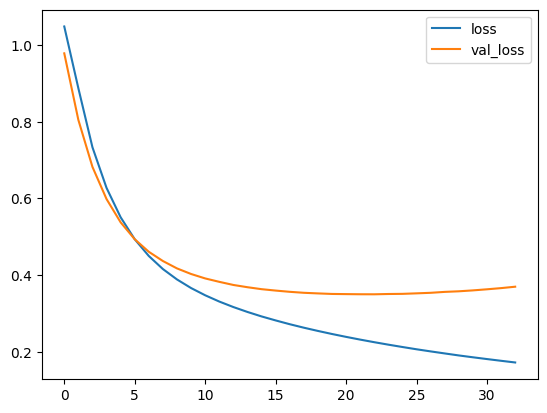

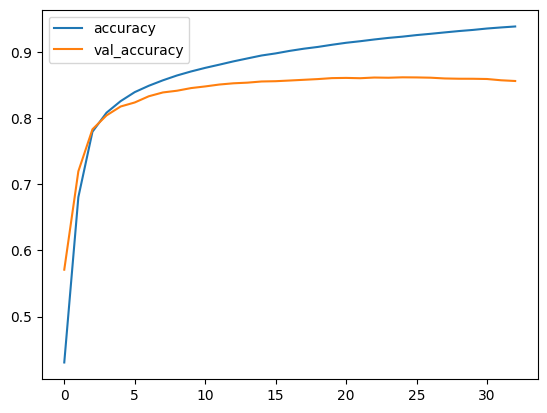

In [37]:
%%time

import tensorflow as tf
import shutil
from tensorflow.keras import callbacks

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 10

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
	X_train, Y_train,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_data=(X_valid, Y_valid),
	callbacks=[callbacks.EarlyStopping(patience=PATIENCE)]
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

---

# Design Pattern 3: Feature Cross

## Feature Cross in Tensorflow

In [14]:
import os
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column as fc

In [15]:
CSV_COLUMNS = [
	'weight_pounds',
	'is_male',
	'mother_age',
	'plurality',
  'gestation_weeks',
  'mother_race'
]
LABEL_COLUMN = "weight_pounds"
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0], ["null"]]  # set default values for each column

In [16]:
def features_and_labels(row_data):
  """Splits fatures and labels from feature dictionary
  Args:
    row_data: Dictionary of CSV column names and tensor values
  Returns:
    Dictionary of feature tensors and label tensors
  """
  label = row_data.pop(LABEL_COLUMN)
  return row_data, label

def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  """Loads dataset using the tf.data API from CSV files.
  Args:
    pattern: str, file pattern to glob into list of files
    batch_size: int, the number of exmaples per batch
    mode: tf.estimator.ModeKeys to determine if training or evaluation
  Returns:
    `Dataset` object
  """
  # Make a CSV dataset
  dataset = tf.data.experimental.make_csv_dataset(
    file_pattern=pattern,
    batch_size=batch_size,
    column_names=CSV_COLUMNS,
    column_defaults=DEFAULTS
  )
  
  # Map dataset to features and labels
  dataset = dataset.map(map_func=features_and_labels)
  
  # Shuffle and repeat for training
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(buffer_size=1000).repeat()
  
  # Take advantage of multi-threading; 1=AUTOTUNE
  dataset = dataset.prefetch(buffer_size=1)

  return dataset
  

In [17]:
def create_input_layers():
  """Creates a dictionary of input layers for each feature.
  
  Returns:
    Dictionary of `tf.keras.layers.Input` layers for each input
  """
  inputs = {
    colname: tf.keras.layers.Input(
      name=colname,
      shape=(),
      dtype='float32'
    ) for colname in ["mother_age", "gestation_weeks"]
  }
  
  inputs.update({
    colname: tf.keras.layers.Input(
      name=colname,
      shape=(),
      dtype='string'
    ) for colname in ["is_male", "plurality", "mother_race"]
  })

  return inputs

In [18]:
# To implement a feature cross in tensorflow, we use the tf.feature_column.crossed_column function
# It takes 2 arguments: (1) list of feature keys to be crossed (2) hash bucket size
# The features once crossed will be hashed according to the hash bucket size, so it must be large
# enought to accomodate the new set of variables
def categorical_fc(name, values):
  cat_column = fc.categorical_column_with_vocabulary_list(
    key=name,
    vocabulary_list=values
  )
  return fc.indicator_column(categorical_column=cat_column)

def create_feature_columns():
  feature_columns = {
    colname: fc.numeric_column(key=colname) \
      for colname in ["mother_age", "gestation_weeks"]
  }
  
  feature_columns["is_male"] = categorical_fc(
    "is_male",
    ["True", "False", "Unknown"]
  )
  feature_columns["plurality"] = categorical_fc(
    "plurality",
    ["Single(1)", "Twins(2)", "Triplets(3)", "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"]
  )
  feature_columns["mother_race"] = fc.indicator_column(
    fc.categorical_column_with_hash_bucket(
      "mother_race",
      hash_bucket_size=17,
      dtype=tf.dtypes.string
    )
  )
  # crossed feature
  feature_columns["gender_x_plurality"] = fc.embedding_column(
    fc.crossed_column(
      ["is_male", "plurality"],
      hash_bucket_size=18
    ),
    dimension=2
  )
  
  return feature_columns

In [19]:
feature_columns = create_feature_columns()
print("Feature columns keys: \n{}\n".format(list(feature_columns.keys())))
print("Feature columns values: \n{}\n".format(list(feature_columns.values())))

Feature columns keys: 
['mother_age', 'gestation_weeks', 'is_male', 'plurality', 'mother_race', 'gender_x_plurality']

Feature columns values: 
[NumericColumn(key='mother_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='gestation_weeks', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='is_male', vocabulary_list=('True', 'False', 'Unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='plurality', vocabulary_list=('Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)', 'Multiple(2+)'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=HashedCategoricalColumn(key='mother_race', hash_bucket_size=17, dtype=tf.string)), EmbeddingColumn(categorical_column=CrossedColumn(keys=('is_male', 'plurality'), hash_bucket_

In [20]:
# Define the DNN Model
def get_model_outputs(inputs):
  h1 = layers.Dense(64, activation='relu', name='h1')(inputs)
  h2 = layers.Dense(32, activation='relu', name='h2')(h1)
  output = layers.Dense(units=1, activation='linear', name='weight')(h2)
  return output

def rmse(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

In [21]:
def build_dnn_model():
  inputs = create_input_layers()
  
  feature_columns = create_feature_columns()
  
  # Constructor for DenseFeatures takes a list of numeric columns
  # Functional API in Keras requires: LayerConstructor()(inputs)
  dnn_inputs = layers.DenseFeatures(
		feature_columns=feature_columns.values()
	)(inputs)
  
  output = get_model_outputs(dnn_inputs)
  
  model = tf.keras.Model(inputs=inputs, outputs=output)
  model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
  
  return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gestation_weeks (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 is_male (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 mother_age (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 mother_race (InputLayer)       [(None,)]            0           []                               
                                                      

In [22]:
tf.keras.utils.plot_model(
	model=model,
	show_shapes=False,
 	rankdir="LR"
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
%%time

tf.random.set_seed(33)

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 1000 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 1000

trainds = load_dataset(
	pattern="data/babyweight_train.csv",
	batch_size=TRAIN_BATCH_SIZE,
	mode=tf.estimator.ModeKeys.TRAIN
)

evalds = load_dataset(
	pattern="data/babyweight_eval.csv",
	batch_size=1000,
	mode=tf.estimator.ModeKeys.EVAL
).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(
	trainds,
	validation_data=evalds,
	epochs=NUM_EVALS,
	steps_per_epoch=steps_per_epoch
)

Epoch 1/5
31/31 [==============================] - 5s 59ms/step - loss: 18.8096 - rmse: 3.4453 - mse: 18.8096 - val_loss: 3.2278 - val_rmse: 1.7966 - val_mse: 3.2278
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 1.4383 - rmse: 1.1849 - mse: 1.4383 - val_loss: 1.3445 - val_rmse: 1.1595 - val_mse: 1.3445
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 1.3893 - rmse: 1.1640 - mse: 1.3893 - val_loss: 1.2765 - val_rmse: 1.1298 - val_mse: 1.2765
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 1.2533 - rmse: 1.1092 - mse: 1.2533 - val_loss: 1.2692 - val_rmse: 1.1266 - val_mse: 1.2692
Epoch 5/5
31/31 [==============================] - 0s 16ms/step - loss: 1.2772 - rmse: 1.1154 - mse: 1.2772 - val_loss: 1.1102 - val_rmse: 1.0537 - val_mse: 1.1102
CPU times: total: 7.66 s
Wall time: 7.04 s


---

# Design Pattern 4: Multimodal Inputs

Both: 

* Combining different types of data together
* Representing the same input in multiple formats

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras import Model
from keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

## Combining text and tabular inputs

In [3]:
reviews_data = {
	"review_text": ["The food was great, but it took forever to get seated.", "The tacos were life changing.", "This food made me question the presence of my taste buds."],
	"meal_type": ["lunch", "dinner", "dinner"],
	"meal_total": [50, 75, 60],
	"rating": [4, 5, 1]
}

In [4]:
# Process review_text to be fed as an embedding
vocab_size = 50
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(reviews_data['review_text'])

reviews_train = tokenize.texts_to_sequences(reviews_data['review_text'])
max_sequence_len = 20
reviews_train = keras.preprocessing.sequence.pad_sequences(
	reviews_train,
  maxlen=max_sequence_len,
  padding='post'
)

print(reviews_train)

[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0]
 [ 1 12 13 14 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [16  2 17 18 19  1 20 21 22 23 24  0  0  0  0  0  0  0  0  0]]


In [5]:
# Convert meal_type into a one-hot
possible_meal_vocab = ['breakfast', 'lunch', 'dinner']
one_hot_meals = []

for i in reviews_data['meal_type']:
  one_hot_arr = [0] * len(possible_meal_vocab)
  one_index = possible_meal_vocab.index(i)
  one_hot_arr[one_index] = 1
  one_hot_meals.append(one_hot_arr)

In [6]:
# Combine one-hot meal_type with meal_total into single array
tabular_features = np.concatenate(
  (
		np.array(one_hot_meals),
		np.expand_dims(reviews_data['meal_total'], axis=1)
	),
  axis=1                                
)
tabular_features

array([[ 0,  1,  0, 50],
       [ 0,  0,  1, 75],
       [ 0,  0,  1, 60]])

In [7]:
# Build tabular and embedding layers with Keras Functional API
batch_size = len(reviews_data['review_text'])

embedding_input = Input(shape=(max_sequence_len, ))
embedding_layer = Embedding(batch_size, 64)(embedding_input)
embedding_layer = Flatten()(embedding_layer)
embedding_layer = Dense(3, activation='relu')(embedding_layer)

tabular_input = Input(shape=(len(tabular_features[0]), ))
tabular_layer = Dense(32, activation='relu')(tabular_input)

In [8]:
# Concatenate layers into a model
merged_inputs = keras.layers.concatenate([embedding_layer, tabular_layer])
merged_dense = Dense(16)(merged_inputs)
output = Dense(1)(merged_dense)

model = Model(inputs=[embedding_input, tabular_input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 64)       192         ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 1280)         0           ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                              

## Tabular Data Multiple Ways

Representing rating as a feature in 2 different ways

In [9]:
def good_or_bad(rating):
  if rating > 3:
    return 1
  else:
    return 0

rating_processed = []

for i in reviews_data['rating']:
  rating_processed.append([i, good_or_bad(i)])

print(rating_processed)

[[4, 1], [5, 1], [1, 0]]


## Mixed Text Representations

Use a Stack Overflow dataset containing questions and answers related to tensorflow, keras and ML related questions to create a model that represents text both as an _Embedding_ and a _Bag of Words_

In [ ]:
%%bigquery df --project your-project
SELECT
  title,
  answer_count,
  REPLACE(tags, "|", ",") as tags
FROM
  `bigquery-public-data.stackoverflow.posts_questions`
WHERE
  REGEXP_CONTAINS( tags, r"(?:keras|matplotlib|pandas)")
LIMIT 1000

In [ ]:
df.head()

In [ ]:
# Define the vocab size and max sequence length + Vectorizer
stacko_vocab_size = 200
stacko_sequence_len = 40

stacko_tokenize = keras.preprocessing.text.Tokenizer(
	num_words=stacko_vocab_size
)
stacko_tokenize.fit_on_texts(df['title'].values)
list(stacko_tokenize.word_index.keys())[:20]

In [ ]:
# Convert questions to sequences for Embedding representation
questions_train_embedding = stacko_tokenize.texts_to_sequences(df['title'].values)
questions_train_embedding = keras.preprocessing.sequence.pad_sequences(
	questions_train_embedding,
	maxlen=stacko_sequence_len,
	padding='post'
)
questions_train_embedding[0]

In [ ]:
# Create BoW representation
questions_train_matrix = stacko_tokenize.texts_to_matrix(df['title'].values)
questions_train_matrix[0]

In [ ]:
# Create Embedding and BoW input layers
batch_size = len(df)

embedding_input = Input(shape=(stacko_sequence_len,))
embedding_layer = Embedding(batch_size, 64)(embedding_input)
embedding_layer = Flatten()(embedding_layer)
embedding_layer = Dense(32, activation='relu')(embedding_layer)

bow_input = Input(shape=(stacko_vocab_size,))
bow_layer = Dense(32, activatation='relu')(bow_input)

In [ ]:
# Create the model with the Embeddings and BoW layers
merged_text_inputs = keras.layers.concatenate([embedding_layer, bow_layer])
merged_dense_text = Dense(16)(merged_text_inputs)
merged_output = Dense(1)(merged_dense_text)

model = Model(inputs=[embedding_input, bow_input], output=merged_output)
model.summary()

## Mixed Image Representations

No dataset used here. Example here merges both pixel values and tiled representations

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dense

# Define image input layer (same shape for both pixel and tiled representations)
image_input = Input(shape=(28, 28, 3))

# Define pixel representation
pixel_layer = Flatten()(image_input)

# Define tiled representation
tiled_layer = Conv2D(
	filters=16,
	kernel_size=3,
 	activation='relu'
)(image_input)
tiled_layer = MaxPooling2D()(tiled_layer)
tiled_layer = tf.keras.layers.Flatten()(tiled_layer)

In [11]:
merged_image_layers = keras.layers.concatenate([pixel_layer, tiled_layer])
merged_dense = Dense(16, activation='relu')(merged_image_layers)
merged_output = Dense(1)(merged_dense)

mixed_image_model = Model(inputs=image_input, outputs=merged_output)

In [12]:
mixed_image_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 26, 26, 16)   448         ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 13, 16)  0           ['conv2d_3[0][0]']               
                                                                                                  
 flatten_6 (Flatten)            (None, 2352)         0           ['input_6[0][0]']                
                                                                                              

### Combining images and metadata

Combination of image data through a convolutional layer and metadata (of various types) represented as tabular data

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dense
import numpy as np

tabular_image_metadata = {
  'time': [9,10,2],
	'visibility': [0.2, 0.5, 0.1],
	'inclement_weather': [[0,0,1], [0,0,1], [1,0,0]],
	'location': [[0,1,0,0,0], [0,0,0,1,0], [1,0,0,0,0]] 
}

In [3]:
# Concatenate all tabular data
tabular_image_features = np.concatenate((
    np.expand_dims(tabular_image_metadata['time'], axis=1),
    np.expand_dims(tabular_image_metadata['visibility'], axis=1),    
    np.array(tabular_image_metadata['inclement_weather']),
    np.array(tabular_image_metadata['location'])
), axis=1)
tabular_image_features

array([[ 9. ,  0.2,  0. ,  0. ,  1. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [10. ,  0.5,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 2. ,  0.1,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ]])

In [ ]:
# Define tabular layer 
image_tabular_input = Input(shape=(len(tabular_image_features[0]), ))
image_tabular_layer = Dense(32, activation='relu')(image_tabular_input)

In [ ]:
# Merge tabular data with tiled layer
mixed_image_layer = keras.layers.concatenate([image_tabular_layer, tiled_layer])

merged_image_dense = Dense(16, activation='relu')(mixed_image_layer)
merged_image_output = Dense(1)(merged_image_dense)

mixed_image_tabular_model = Model(inputs=[image_tabular_input, tiled_input], outputs=merged_image_output)